In [1]:
from sim_env import FixedSimEnv, flag_departure_event, relevant_schedule, recommended_dep_t
from copy import deepcopy
import pandas as pd
import numpy as np
from data_handlers import GTFSHandler, AVLHandler, bpf, write_sim_data, ODXHandler
from itertools import product
from constants import *
import zipfile
import seaborn as sns

In [9]:
pax = pd.read_csv('data/sim_out/experiments_0611-2304/pax.csv')

trips = pd.read_csv('data/sim_out/experiments_0611-2304/trips.csv')
for ky in ('arrival', 'departure', 'schd'):
    full_ky = ky + '_time_sec'
    trips[full_ky] = pd.to_datetime(trips[full_ky]).dt.round("S")

for ky in ('arrival', 'alighting', 'boarding'):
    full_ky = ky + '_time'
    pax[full_ky] = pd.to_datetime(pax[full_ky]).dt.round("S")

In [17]:
am_pax = pax[pax['arrival_time'].dt.hour.isin([6,7,8])].copy()
am_pax['wait_time'] = am_pax['boarding_time'] - am_pax['arrival_time']
am_pax['date'] = am_pax['arrival_time'].dt.date

In [21]:
results = am_pax.groupby(['scenario','route_id', 'direction'])['wait_time'].mean().reset_index()
results['wait_time'] = results['wait_time'].round("S")

In [22]:
results

,scenario,route_id,direction,wait_time
0,EHD,81,East,0 days 00:07:41
1,EHD,81,West,0 days 00:07:16
2,EHD,91,North,0 days 00:09:20
3,EHD,91,South,0 days 00:08:21
4,EHD,92,East,0 days 00:06:09
5,EHD,92,West,0 days 00:05:43
6,NC,81,East,0 days 00:08:22
7,NC,81,West,0 days 00:07:45
8,NC,91,North,0 days 00:09:46
9,NC,91,South,0 days 00:09:19


In [53]:
def compute_headways(veh, line, earliest_dep_t, route, 
                     terminal=False, layover_bus_dep=None): # CHANGE 1
        if terminal:
            trip_id = veh.next_trips[0].id
            direction = veh.next_trips[0].direction
            stop_idx = 0
            stops = veh.next_trips[0].stops
        else:
            trip_id = veh.curr_trip.id
            direction = veh.curr_trip.direction
            stop_idx = veh.stop_idx
            stops = veh.curr_trip.stops
        # preceding headway (WATCH OUT FOR EXTREME BUNCHING CASES WITH ONE BUS AT THE STOP)
        if layover_bus_dep is not None:
            last_dep_time = deepcopy(layover_bus_dep)
        else:
            last_dep_time = route.stops[direction][stop_idx].last_dep_time

        # pre_hw = deepcopy(last_dep_time) if last_dep_time is None else time - last_dep_time
        # if pre_hw is not None and pre_hw < 0:
        #     print('negative preceding headway')
        #     print('time ' + str(pd.to_timedelta(round(time), unit='S')))
        #     print('')
        pre_hw = None 
        true_earliest_dep_t = deepcopy(earliest_dep_t)
        if last_dep_time is not None:
            true_earliest_dep_t = max(earliest_dep_t, last_dep_time)
            pre_hw = true_earliest_dep_t - last_dep_time
            if pre_hw == 0:
                print('almost a negative preceding headway')
                print('earliest departure time ' + str(pd.to_timedelta(round(earliest_dep_t), unit='S')))
                print('last departure time ' + str(pd.to_timedelta(round(last_dep_time), unit='S')))
                print('true earliest ' + str(pd.to_timedelta(round(true_earliest_dep_t), unit='S')))
                print('')
        
        # next headway
        last_dep_time = None
        last_dep_stop_idx = None
        for i in range(stop_idx-1, -1, -1):
            # print('huh?')
            last_dep_trip = route.stops[direction][i].last_dep_trip
            if last_dep_trip is not None and last_dep_trip != trip_id:
                last_dep_time = route.stops[direction][i].last_dep_time
                last_dep_stop_idx = deepcopy(i)
                break

        if last_dep_time is None:
            # check schedules
            schd = route.schedule.copy()
            schd_time = schd.loc[(schd['schd_trip_id']==trip_id) &
                                 (schd['stop_sequence']==1), 'departure_time_sec'].values[0]
            next_departure = schd.loc[(schd['confirmed']==1) & 
                                    (schd['departure_time_sec']>max(schd_time, earliest_dep_t)) & 
                                    (schd['stop_sequence']==1) &
                                    (schd['direction']==direction), 'departure_time_sec'].iloc[0]
            # print(str(pd.to_timedelta(round(time), unit='S')))
            # compute travel times
            tot_travel_time = 0
            for i in range(stop_idx):
                first = True if i == 0 else False
                tot_travel_time += line.link_time_from_interval(stops[i], stops[i+1], 
                                                                earliest_dep_t+tot_travel_time, veh.route_id,
                                                                edge_link=first)
            next_hw = next_departure + tot_travel_time - earliest_dep_t
            # print(f'from terminal to stop {stop_idx}')
            td = pd.to_timedelta(round(next_departure), unit='S')
            td2 = pd.to_timedelta(round(tot_travel_time), unit='S')
            print(f'next departure {str(td)} and travel time {str(td2)}')
        else:
            tot_travel_time = 0
            for i in range(last_dep_stop_idx,stop_idx):
                first = True if i == 0 else False
                tot_travel_time += line.link_time_from_interval(stops[i], stops[i+1], 
                                                                earliest_dep_t+tot_travel_time, veh.route_id,
                                                                edge_link=first)
            # print(str(pd.to_timedelta(round(time), unit='S')))
            next_hw = last_dep_time + tot_travel_time - earliest_dep_t
            # print(f'from terminal to stop {last_dep_stop_idx} to stop {stop_idx}')
            td = pd.to_timedelta(round(last_dep_time), unit='S')
            td2 = pd.to_timedelta(round(tot_travel_time), unit='S')
            # print(f'departure {str(td)} and travel time {str(td2)}')
        return pre_hw, next_hw

In [18]:
def flag_departure_event(info):
    tmp_info = info[info['t_since_last'].notna()].copy()
    outbound_terminals = [OUTBOUND_TERMINALS[rt][0] for rt in ROUTES]
    flag_vehicle = tmp_info[(tmp_info['stop_id'].isin(outbound_terminals)) & 
                            (tmp_info['status'].isin([1,4])) & 
                            (tmp_info['t_since_last']==pd.to_timedelta(0, unit='S'))].copy()
    return flag_vehicle

In [2]:
i = 0

env = FixedSimEnv()

In [5]:
unique_dates = env.link_times['date'].unique()
np.random.choice(unique_dates, replace=False, size=3)

array(['2022-11-28', '2022-12-07', '2022-11-21'], dtype=object)

In [121]:

next_obs, rew, done, info = env.reset()
print(env.lines[ROUTES[0]].hist_date)

2022-12-05


In [ ]:
next_obs, rew, done = env.step()

In [115]:
next_obs, rew, done, info = env.reset()
print(env.lines[ROUTES[0]].hist_date)
i = 0

schd = env.routes['91'].schedule.copy()
ref_trips = schd[(schd['stop_id']==14103) & (schd['stop_sequence']==1)].copy()
ref_trips[['block_id','arrival_time', 'confirmed']].head(12)

2022-12-02


,block_id,arrival_time,confirmed
0,652000002631,05:12:00,1
27,652000002581,05:25:30,1
75,652000002632,05:39:00,1
138,652000002541,05:52:30,1
220,652000002603,06:05:00,1
288,652000002561,06:13:30,1
374,652000002595,06:22:30,1
480,652000002545,06:32:00,1
582,652000002631,06:41:30,1
781,652000002581,07:01:00,1


In [116]:
while not done and i < MAX_STEPS:
    next_obs, rew, done, info = env.step()

    if not done:
        control_vehs = flag_departure_event(info)

        if not control_vehs.empty:
            control_veh = env.vehicles[control_vehs.index[0]]
            rt_id = control_vehs['route_id'].iloc[0]
            if rt_id=='91' and control_veh.block_id==652000002631 and env.time > 6*60*60:
                
                schd_dep_t = control_veh.next_trips[0].schedule['departure_time_sec'].values[0]
                earliest_dep_t = max(schd_dep_t-MAX_EARLY_DEV*60, env.time)

                layover_buses = info[(info['route_id']==control_veh.route_id) & 
                                    (info['stop_id']==control_vehs['stop_id'].iloc[0]) & 
                                    (info['status'].isin([1,2,4])) & 
                                    (info['stop_sequence']==1) &
                                    (info['trip_sequence'] < control_vehs['trip_sequence'].iloc[0])].copy()

                                    # (info['id'] != control_vehs['id'].iloc[0])].copy()
                layover_bus_dep = None
                if not layover_buses.empty:
                    layover_bus_dep = layover_buses['next_event_t'].max().total_seconds()

                    ## NEW
                    layover_seq = layover_buses['trip_sequence'].tolist()
                    curr_trip_seq = control_vehs['trip_sequence'].iloc[0]
                    print(f'layover trip sequence {layover_seq}')
                    print(f'current trip sequence {curr_trip_seq}')

                # pre_hw, next_hw = control_veh.compute_headways(
                #     env.lines[rt_id], earliest_dep_t, env.routes[rt_id], terminal=True,
                #     layover_bus_dep=layover_bus_dep)

                pre_hw, next_hw = compute_headways(control_veh,
                    env.lines[rt_id], earliest_dep_t, env.routes[rt_id], terminal=True, 
                    layover_bus_dep=layover_bus_dep)

                if pre_hw is not None and next_hw is not None:
                    if pre_hw >= 0:
                        latest_dep_t = max(schd_dep_t+MAX_LATE_DEV*60, env.time)
                        rec_dep_t = recommended_dep_t(pre_hw, next_hw, env.time)
                        dep_t = min(latest_dep_t, rec_dep_t)
                        dep_t = max(earliest_dep_t, dep_t)

                        earliest_td = pd.to_timedelta(round(earliest_dep_t), unit='S')
                        time_td = pd.to_timedelta(round(env.time), unit='S')
                        sch_td = pd.to_timedelta(round(schd_dep_t), unit='S')
                        latest_td = pd.to_timedelta(round(latest_dep_t), unit='S')
                        rec_td = pd.to_timedelta(round(rec_dep_t), unit='S')
                        dep_td = pd.to_timedelta(round(dep_t), unit='S')
                        pre_td = pd.to_timedelta(round(pre_hw), unit='S')
                        post_td = pd.to_timedelta(round(next_hw), unit='S')

                        print(f'time {time_td}')
                        print(f'headways {pre_td} and {post_td}')
                        print(f'scheduled departure {sch_td}')
                        print(f'latest departure {latest_td}')
                        print(f'earliest departure {earliest_td}')
                        print(f'recommended departure {rec_td}')
                        print(f'departure time {dep_td}')

                        # if dep_t > control_veh.next_event['t']:
                        #     control_veh.next_event['t'] = deepcopy(dep_t)
                        #     new_df_info = env._get_info_vehicles()
                        #     new_df_info['nr_step'] = deepcopy(env.step_counter)
                        #     env.info_records[-1] = new_df_info.copy()
                    i += 1

                break

next departure 0 days 07:01:00 and travel time 0 days 00:00:00
time 0 days 06:34:34
headways 0 days 00:04:19 and 0 days 00:24:30
scheduled departure 0 days 06:41:30
latest departure 0 days 06:46:30
earliest departure 0 days 06:36:30
recommended departure 0 days 06:44:39
departure time 0 days 06:44:39


In [94]:
veh = [v for v in env.vehicles if v.block_id==652000002545]

In [36]:
control_vehs

,time,nr_step,id,active,status,status_desc,next_event,next_event_t,t_until_next,stop_id,stop_sequence,direction,pax_load,t_since_last,route_id,trip_id,trip_sequence
19,0 days 06:37:42.900000,2969,652000002631,0,1,inactive - terminal turnaround,terminal boarding,0 days 06:41:30,0 days 00:03:47.100000,14103,1,South,0,0 days,91,39674020,9


In [124]:
tri1 = pd.read_csv('data/sim_out/experiments_0413-1258/trips.csv')
# tri2 = pd.read_csv('data/sim_out/experiments_0413-1258/EHD/trips.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/sim_out/experiments_0413-1258/trips.csv'

In [119]:
def headways(trips, rt, direction):
    tr = trips[(trips['stop_sequence']==1) & 
               (trips['route_id']==rt) & 
               (trips['direction']==direction)].copy()
    tr = tr.sort_values(by='departure_time_sec')
    tr['headway'] = tr['departure_time_sec'].diff()
    tr['schd_headway'] = tr['schd_time_sec'].diff()
    tr['schd_time'] = pd.to_timedelta(tr['schd_time_sec'], unit='S')
    tr['arr_time'] = pd.to_timedelta(tr['arrival_time_sec'].round(), unit='S')
    tr['dep_time'] = pd.to_timedelta(tr['departure_time_sec'].round(), unit='S')
    return tr[['stop_id', 'trip_id', 'run_id', 'route_id', 
               'block_id', 'headway', 'schd_headway',
               'arr_time', 'dep_time', 'schd_time']]

In [132]:
hws = headways(tri2, 91, 'South')

In [133]:
hws['arr_time'] += pd.to_datetime('2022-11-15')

In [134]:
hws

,stop_id,trip_id,run_id,route_id,block_id,headway,schd_headway,arr_time,dep_time,schd_time
1596,14103,11565020,F166,91,652000002631,NaN,NaN,2022-11-15 05:12:00,0 days 05:12:07,0 days 05:12:00
1923,14103,22253020,F167,91,652000002581,900.265343,810.0,2022-11-15 05:27:08,0 days 05:27:08,0 days 05:25:30
2250,14103,11129020,F162,91,652000002632,769.842550,810.0,2022-11-15 05:39:49,0 days 05:39:58,0 days 05:39:00
2512,14103,1600020,F169,91,652000002541,763.990131,810.0,2022-11-15 05:52:30,0 days 05:52:42,0 days 05:52:30
2774,14103,38586020,F164,91,652000002603,749.375187,750.0,2022-11-15 06:05:00,0 days 06:05:11,0 days 06:05:00
3036,14103,24452020,F168,91,652000002561,555.835378,510.0,2022-11-15 06:14:10,0 days 06:14:27,0 days 06:13:30
3298,14103,28414020,F111,91,652000002595,539.533389,540.0,2022-11-15 06:23:13,0 days 06:23:26,0 days 06:22:30
3494,14103,16130020,F161,91,652000002545,552.496227,570.0,2022-11-15 06:32:28,0 days 06:32:39,0 days 06:32:00
1727,14103,39674020,F166,91,652000002631,538.717169,570.0,2022-11-15 06:41:30,0 days 06:41:38,0 days 06:41:30
2054,14103,38441020,F167,91,652000002581,1175.814665,1170.0,2022-11-15 07:01:00,0 days 07:01:13,0 days 07:01:00


In [7]:
schd = pd.read_csv('data/sim_in/schedule.csv')

In [ ]:
sch

In [18]:
schd[(schd['route_id']==91) & (schd['direction']=='South') & (schd['stop_sequence']==1)].sort_values(by='arrival_time').iloc[8:30]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,shape_dist_traveled,schd_trip_id,direction,block_id,route_id,shape_id,trip_sequence,runid
6976,6520039674020,06:41:30,06:41:30,14103,1,Roosevelt,0,0,39674020,South,652000002631,91,65202945,9,F166
10297,6520038441020,07:01:00,07:01:00,14103,1,Roosevelt,0,0,38441020,South,652000002581,91,65202945,10,F167
24095,6520048610020,07:11:00,07:11:00,14103,1,Roosevelt,0,0,48610020,South,652000002632,91,65202945,11,F162
15410,6520008183020,07:21:30,07:21:30,14103,1,Roosevelt,0,0,8183020,South,652000002534,91,65202945,12,F661
8490,6520037199020,07:32:30,07:32:30,14103,1,Roosevelt,0,0,37199020,South,652000002541,91,65202945,13,F169
19521,6520004650020,07:43:30,07:43:30,14103,1,Roosevelt,0,0,4650020,South,652000002603,91,65202945,14,F164
12630,6520012758020,07:54:30,07:54:30,14103,1,Roosevelt,0,0,12758020,South,652000002561,91,65202945,15,F168
11066,6520037542020,08:06:00,08:06:00,14103,1,Roosevelt,0,0,37542020,South,652000002595,91,65202945,16,F111
19407,6520025084020,08:18:00,08:18:00,14103,1,Roosevelt,0,0,25084020,South,652000002545,91,65202945,17,F163
23049,6520019496020,08:30:30,08:30:30,14103,1,Roosevelt,0,0,19496020,South,652000002631,91,65202945,18,F166


In [2]:
# define line characteristics
gtfs_handler = GTFSHandler('data/gtfs/' + GTFS_ZIP_FILE)
gtfs_handler.load_network(START_DATE, END_DATE, ROUTES)
gtfs_handler.load_schedule(DATA_START_TIME, DATA_END_TIME, 
                            OUTBOUND_DIRECTIONS, INBOUND_DIRECTIONS, ROUTES)

schedule = gtfs_handler.schedule.copy()
stops = gtfs_handler.route_stops.copy()

/Users/joseph/transit-centric-smart-mobility-system/src/04_SIMULATION/data_handlers.py:83: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.stop_times = pd.read_csv(self.zf.open('stop_times.txt'))
/Users/joseph/transit-centric-smart-mobility-system/src/04_SIMULATION/data_handlers.py:87: DtypeWarning: Columns (1,2,5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  self.trips = pd.read_csv(self.zf.open('trips.txt'))


In [4]:
schd = gtfs_handler.stop_times.copy()

In [ ]:
schd[(schd['stop_id']==3725) & (schd['stop_sequence']==2) & (schd['arrival_time'].str[:4]=='06:5')]

In [14]:
schedule[(schedule['route_id']=='91') & 
         (schedule['direction']=='South') & 
         (schedule['stop_sequence']==2)].sort_values(by='arrival_time').iloc[7:20]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,shape_dist_traveled,schd_trip_id,direction,block_id,route_id,shape_id,monday,tuesday,wednesday,thursday,friday,trip_sequence
13826,6520016130020,06:32:20,06:32:20,3725,2,Roosevelt,0,422,16130020,South,652000002545,91,65202945,1,1,1,1,1,8
6977,6520039674020,06:41:50,06:41:50,3725,2,Roosevelt,0,422,39674020,South,652000002631,91,65202945,1,1,1,1,1,9
10298,6520038441020,07:01:20,07:01:20,3725,2,Roosevelt,0,422,38441020,South,652000002581,91,65202945,1,1,1,1,1,10
24096,6520048610020,07:11:20,07:11:20,3725,2,Roosevelt,0,422,48610020,South,652000002632,91,65202945,1,1,1,1,1,11
15411,6520008183020,07:21:50,07:21:50,3725,2,Roosevelt,0,422,8183020,South,652000002534,91,65202945,0,1,1,0,1,12
8491,6520037199020,07:32:50,07:32:50,3725,2,Roosevelt,0,422,37199020,South,652000002541,91,65202945,1,1,1,1,1,13
19522,6520004650020,07:43:52,07:43:52,3725,2,Roosevelt,0,422,4650020,South,652000002603,91,65202945,1,1,1,1,1,14
12631,6520012758020,07:54:52,07:54:52,3725,2,Roosevelt,0,422,12758020,South,652000002561,91,65202945,1,1,1,1,1,15
11067,6520037542020,08:06:22,08:06:22,3725,2,Roosevelt,0,422,37542020,South,652000002595,91,65202945,1,1,1,1,1,16
19408,6520025084020,08:18:22,08:18:22,3725,2,Roosevelt,0,422,25084020,South,652000002545,91,65202945,1,1,1,1,1,17


In [83]:
pax1 = pd.read_csv('data/sim_out/experiments_0607-0053/NC/pax.csv')
pax2 = pd.read_csv('data/sim_out/experiments_0607-0053/EHD/pax.csv')

In [91]:
arr0 = 20300
arr1 = 30000

In [92]:
def wait_t(df, st, et):
    wdf = df[(df['arrival_time'] > st) & (df['arrival_time'] < et)].copy()
    wdf['wait'] = wdf['boarding_time'] - wdf['arrival_time']
    return wdf[['boarding_stop', 'alighting_stop', 'route_id', 'wait', 'direction']]

In [97]:
w1 = wait_t(pax1, arr0, arr1)
w2 = wait_t(pax2, arr0, arr1)

w1 = w1.groupby(['route_id', 'direction'])['wait'].mean().reset_index()
w2 = w2.groupby(['route_id','direction'])['wait'].mean().reset_index()

In [98]:
for w, k in zip([w1, w2], ['DN', 'EHD']):
    w['rt_dir'] = w['route_id'].astype(str) + '-' + w['direction']
    w['scenario'] = k

In [100]:
results = pd.concat([w1, w2], ignore_index=True)

<AxesSubplot: xlabel='rt_dir', ylabel='wait'>

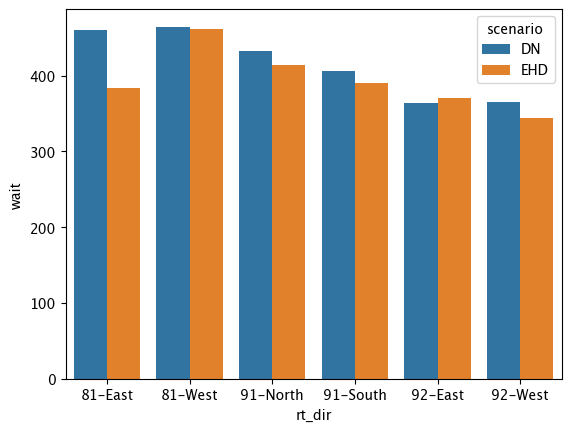

In [103]:
sns.barplot(data=results, hue='scenario', y='wait', x='rt_dir')

In [3]:
schds = relevant_schedule(env.routes, env.time, OUTBOUND_TERMINALS)

In [ ]:
schds

In [4]:
stops = gtfs_handler.route_stops.copy()
schedule = gtfs_handler.schedule.copy()
am_schd = schedule[(schedule['arrival_time'].str[:2].isin(['05','06', '07','08', '09']))].copy()
# am_schd[(schedule['stop_sequence']==1)].groupby(['route_id', 'direction', 'shape_id']).size()

for r in ROUTES:
    schd = am_schd[am_schd['route_id']==r].copy()
    for d in schd['direction'].unique():
        schd_d = schd[schd['direction']==d].copy()
        first_stop = schd_d.loc[schd_d['stop_sequence']==1, 'stop_id'].unique()
        last_stop = schd_d.loc[schd_d['stop_sequence']==schd_d['stop_sequence'].max(), 'stop_id'].unique()
        print(f'route {r} direction {d}')
        print(f'first stop {first_stop}')
        print(f'last stop {last_stop}')

In [7]:
sched_df = pd.read_csv('data/sim_data/schedule.csv')
lt_df = pd.read_csv('data/sim_data/link_times.csv')

terminal_df = sched_df[sched_df['stop_sequence']==1].copy()
terminal_df['block_id'] = terminal_df['block_id'].astype(int)

# COUNT BLOCKS AND RUNS
blocks = terminal_df.groupby('block_id')['trip_id'].count().reset_index()
runs = terminal_df.groupby('runid')['trip_id'].count().reset_index()

run_blocks = terminal_df.groupby('runid')['block_id'].median().reset_index() # DUBIOUS WAY TO CLASSIFY
run_blocks['block_id'] = run_blocks['block_id'].astype(int)
run_blocks.sort_values(by='block_id').head(8)

In [50]:
from sim_env import FixedSimEnv, flag_departure_event, recommended_dep_t
import pandas as pd
import numpy as np
from constants import *
from copy import deepcopy
# import matplotlib.pyplot as plt
from utils import plot_situation

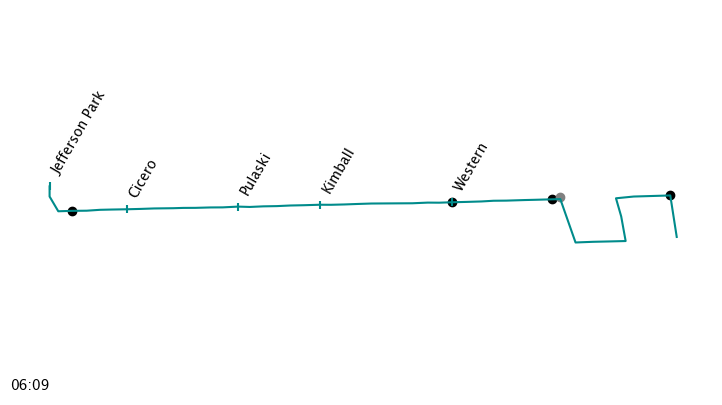

In [46]:
plot_situation(env.info_records[-1], stops_e, key_stops_e)

In [78]:
trip_records = []
for veh in env.vehicles:
    if not veh.trip_records.empty:
        trip_records.append(veh.trip_records)

In [ ]:
env.vehicles[0].trip_records

In [2]:
import pandas as pd

In [10]:
pax_ehd = pd.read_csv('data/sim_out/experiments_0502-1702/EHD/pax.csv')
pax_nc = pd.read_csv('data/sim_out/experiments_0502-1702/NC/pax.csv')

trips_ehd = pd.read_csv('data/sim_out/experiments_0502-1702/EHD/trips.csv')
trips_nc = pd.read_csv('data/sim_out/experiments_0502-1702/NC/trips.csv')

In [56]:
import os
from constants import *
import pandas as pd
from utils import get_results

In [57]:
start_time = 7*60*60
end_time = 9*60*60
res = get_results('0529-1244', ['EHD', 'NC'], start_time, end_time)

In [58]:
res

,metric,EHD,NC,prc_imp
0,wait_t,400.707234,428.567115,-6.50
1,rbt,230.607529,269.710561,-14.50
2,denied,0.000000,0.000000,NaN
3,sd_load_pk_e,12.185454,10.715895,13.71
4,run_time_e_95,3446.030911,3667.399587,-6.04
5,run_time_w_95,3251.998410,3198.981979,1.66
